Visualizing unstructured data
==========
Example visualization of unstructured ICON and UGRID data.

Here we show, how the psy-maps plugin can visualize the unstructured grid of the Earth System Model [ICON](http://www.mpimet.mpg.de/en/science/models/icon-esm.html) from the Max-Planck-Institute for Meteorology in Hamburg, Germany, and data following the unstructured grids ([UGRID](http://ugrid-conventions.github.io/ugrid-conventions/)). The visualization works the same as for normal rectilinear grids. Internally, however, the coordinates are interpreted in a completely different way (see below for a detailed explanation).

In [1]:
import psyplot.project as psy
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.close_figures = False

In [2]:
psy.rcParams['plotter.maps.xgrid'] = False
psy.rcParams['plotter.maps.ygrid'] = False
mpl.rcParams['figure.figsize'] = [10., 8.]

## Visualizing UGRID data
A widely accepted approach for unstructured grids are the so-called UGRID Conventions. For a demonstration, we use the `'ugrid_demo.nc'` netCDF file that contains sea surface height of a Tsunami simulation. We use the `load` parameter, to directly load it into memory. That speeds up the plotting of the data.

psyplot automatically recognizes the UGRID conventions and adapts it's plotting algorithm for displaying the data. For this simulation, let's focus on Japan. We use the `maskleq` keyword here to mask the land surface and display a `stock_img` on the continents.

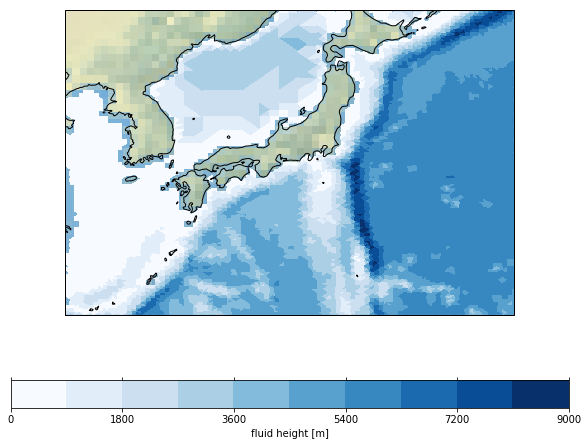

In [3]:
tsunami = psy.plot.mapplot(
    'ugrid_demo.nc', name='Mesh2_height', load=True,
    maskleq=0, lonlatbox='Japan', cmap='Blues', 
    clabel='{desc}', stock_img=True, lsm='50m')

To visualize the unstructured grid, we can use the `datagrid` formatoption. It excepts a string or the line properties.

In [4]:
tsunami.docs('datagrid')

datagrid
Show the grid of the data

This formatoption shows the grid of the data (without labels)

Possible types
--------------
None
    Don't show the data grid
str
    A linestyle in the form ``'k-'``, where ``'k'`` is the color and
    ``'-'`` the linestyle.
dict
    any keyword arguments that are passed to the plotting function (
    :func:`matplotlib.pyplot.triplot` for triangular grids and
    :func:`matplotlib.pyplot.hlines` for rectilinear grids)
See Also
--------
xgrid
ygrid



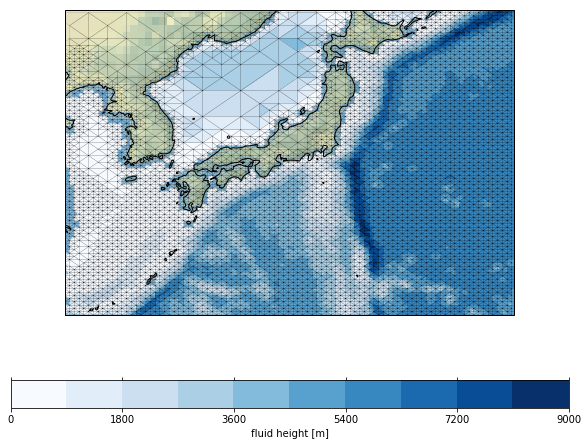

In [5]:
tsunami.update(datagrid={'c': 'k', 'lw': 0.1})
tsunami.show()

In [6]:
tsunami.close()

## Visualizing scalar and vector ICON data

This section requires the psy-maps plugin and the file ```'icon_grid_demo.nc'``` which contains one variable for the temperature, one for zonal and one for the meridional wind direction.

The visualization works the same way as for a usual rectangular grid. We choose a robinson projection and a colormap ranging from blue to red.

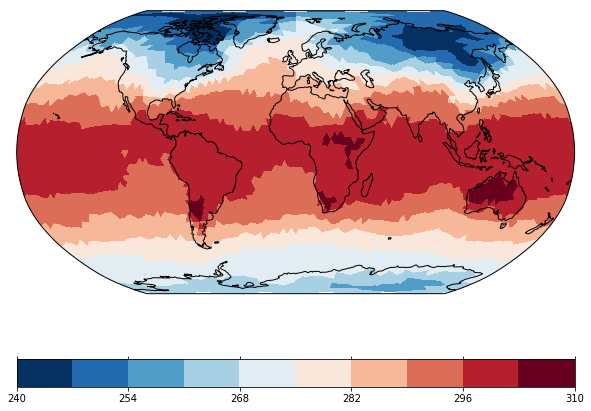

In [7]:
maps = psy.plot.mapplot('icon_grid_demo.nc', name='t2m', projection='robin', 
                        cmap='RdBu_r')

We can again zoom in to Europe and use the `datagrid` formatoption to display the triangular grid.

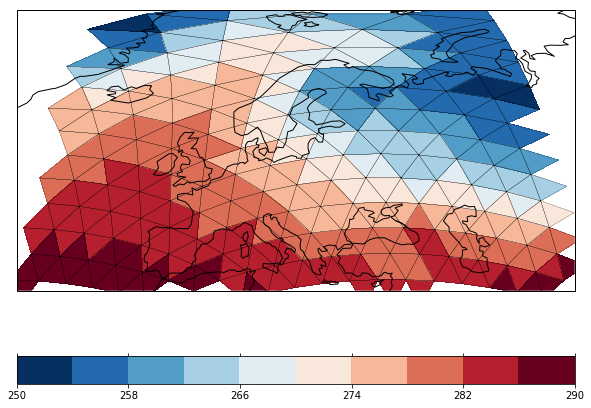

In [8]:
maps.update(lonlatbox='Europe', datagrid=dict(color='k', linewidth=0.2))
maps.show()

The same works for vector data

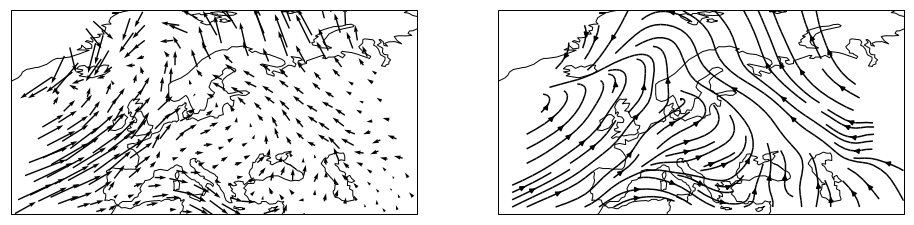

In [9]:
vectors = psy.plot.mapvector(
    'icon_grid_demo.nc', name=[['u', 'v']] * 2, projection='robin', 
    ax=(1, 2), lonlatbox='Europe')
vectors.plotters[0].update(arrowsize=100)
vectors.plotters[1].update(plot='stream')

And combined scalar and vector fields

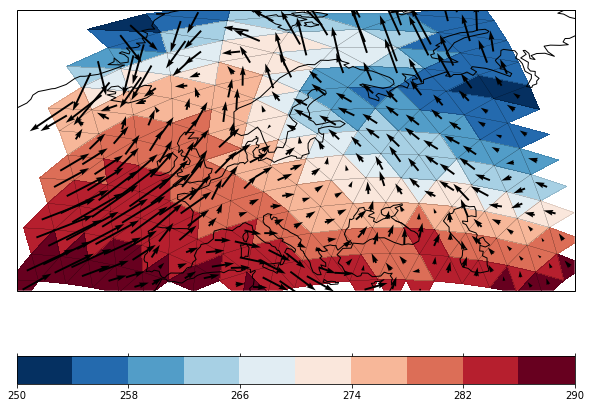

In [10]:
combined = psy.plot.mapcombined(
    'icon_grid_demo.nc', name=[['t2m', ['u', 'v']]], projection='robin',
    lonlatbox='Europe', arrowsize=100, cmap='RdBu_r', datagrid={'c': 'k', 'lw': 0.1})

The `mapplot` plotmethod does also not care about the shape of the grid cells. Therefore it can also visualize the ICON edge grid:

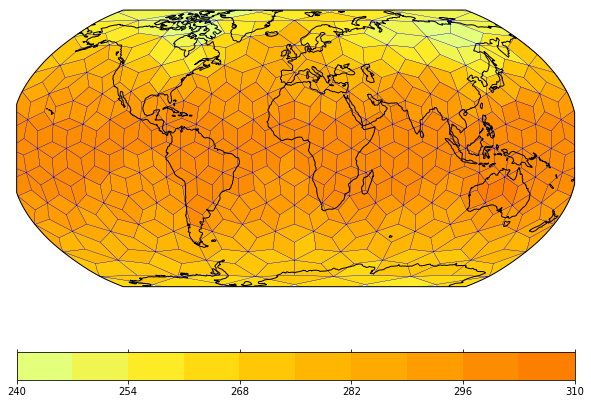

In [11]:
maps = psy.plot.mapplot('icon_grid_demo.nc', name='t2m_edge', projection='robin', 
                        cmap='Wistia', datagrid=dict(c='b', lw=0.2))

## The handling unstructured grids
In this section, we go a bit into detail into how psyplot interpretes unstructured grids. If your data is an ICON file or follows the UGRID Conventions, you might want to skip this section, because then psyplot can handle your data automatically.

### Interpreting the UGRID Conventions
The best way to specify unstructured grids is to follow the unstructured grids ([UGRID](http://ugrid-conventions.github.io/ugrid-conventions/)) conventions. Variables that follow these conventions are then interpreted by the [UGridDecoder](https://psyplot.readthedocs.io/en/latest/api/psyplot.data.html#psyplot.data.UGridDecoder) class. If one variable has a `mesh` attribute, psyplot assumes that it follows the UGRID conventions. 

Furthermore, psyplot interpretes the `location` attribute. Attribute can either live on the `edge`, `face` or the `node` of the grid cell. In case of a variable the lives on the `node`, the data is assumed to be triangular and we plot the data using a Delaunay triangulation.

In [12]:
ds = tsunami[0].psy.base
ds

<xarray.Dataset>
Dimensions:           (Three: 3, Two: 2, nMesh2_edge: 171106, nMesh2_face: 113885, nMesh2_node: 57222, time: 1)
Coordinates:
    Mesh2             int32 -2147483647
    Mesh2_node_x      (nMesh2_node) float32 121.0 142.0 131.5 142.0 136.75 ...
    Mesh2_node_y      (nMesh2_node) float32 -59.2 -59.2 -52.025 -52.025 ...
    Mesh2_face_nodes  (nMesh2_face, Three) int32 0 1 2 2 1 3 2 3 4 4 3 5 4 5 ...
  * time              (time) datetime64[ns] 1950-01-01T04:11:59.999742507
  * nMesh2_face       (nMesh2_face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
Dimensions without coordinates: Three, Two, nMesh2_edge, nMesh2_node
Data variables:
    Mesh2_edge_nodes  (nMesh2_edge, Two) int32 1 2 2 0 0 1 1 3 2 3 3 4 4 2 3 ...
    Mesh2_height      (time, nMesh2_face) float32 4069.1465 3689.5886 ...
    Mesh2_bathy       (time, nMesh2_face) float32 6930.8535 7310.4116 ...
    Mesh2_m_x         (time, nMesh2_face) float32 -3.3569866e-10 ...
    Mesh2_m_y         (time, nMesh2_face) fl

In [13]:
print('Mesh variable of Mesh2_height:', ds.Mesh2_height.mesh)
print('Location of the variable in the grid cell:', ds.Mesh2_height.location)
print('Name of the location variable:', ds.Mesh2.face_node_connectivity)
print('--------------------------------------------')
print('face node connectivity:', ds.Mesh2_face_nodes)

Mesh variable of Mesh2_height: Mesh2
Location of the variable in the grid cell: face
Name of the location variable: Mesh2_face_nodes
--------------------------------------------
face node connectivity: <xarray.DataArray 'Mesh2_face_nodes' (nMesh2_face: 113885, Three: 3)>
array([[    0,     1,     2],
       [    2,     1,     3],
       [    2,     3,     4],
       ...,
       [57219,     2,     4],
       [57218,     2, 57219],
       [57218,     0,     2]], dtype=int32)
Coordinates:
    Mesh2             int32 -2147483647
    Mesh2_face_nodes  (nMesh2_face, Three) int32 0 1 2 2 1 3 2 3 4 4 3 5 4 5 ...
  * nMesh2_face       (nMesh2_face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
Dimensions without coordinates: Three
Attributes:
    cf_role:      face_node_connectivity
    long_name:    Maps every triangular face to its three corner nodes
    start_index:  0


### Interpreting the CF Conventions
However, there is also another way that follows more closely the standard [CF Conventions](http://cfconventions.org/). This is also the way, that ICON uses, namely the netCDF attributes `coordinates` and `bounds`. These two attributes are decoded [CFDecoder](https://psyplot.readthedocs.io/en/latest/api/psyplot.data.html#psyplot.data.CFDecoder) (namely the `DataArray.psy.decoder` attribute) and used for the visualization.

To explain it a bit more, we can look into the `icon_grid_demo.nc` file:

In [14]:
ds = maps[0].psy.base
ds

<xarray.Dataset>
Dimensions:    (edge: 480, lev: 4, ncells: 5120, no: 4, time: 5, vertices: 3)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-31T18:00:00 1979-02-28T18:00:00 ...
    clon       (ncells) float64 ...
    clon_bnds  (ncells, vertices) float64 ...
    clat       (ncells) float64 ...
    clat_bnds  (ncells, vertices) float64 ...
    elon       (edge) float32 ...
    elon_bnds  (edge, no) float32 ...
    elat       (edge) float32 ...
    elat_bnds  (edge, no) float32 ...
  * lev        (lev) float64 1e+05 8.5e+04 5e+04 2e+04
  * edge       (edge) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Dimensions without coordinates: ncells, no, vertices
Data variables:
    t2m        (time, lev, ncells) float32 ...
    u          (time, lev, ncells) float32 ...
    v          (time, lev, ncells) float32 ...
    t2m_edge   (time, lev, edge) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.1 (http://mpimet...
    Conventions:     

This dataset contains two grid definitions, one for variables living on the face of one grid cell (namely `t2m, u, v`) and one for a variable living on the edges of a grid cell (`t2m_edge`). Which grid is chosen, used depends on the `coordinates` attribute of the specific variable:

In [15]:
print('t2m:', ds.t2m.encoding['coordinates'])
print('t2m_edge:', ds.t2m_edge.encoding['coordinates'])

t2m: clat clon
t2m_edge: elat elon


The variables mentioned in these coordinates do then have a `bounds` attribute to the variable with the lat-lon information of the vortices for each grid cell

In [16]:
print(ds.clat.bounds)
ds[ds.clat.bounds]

clat_bnds


<xarray.DataArray 'clat_bnds' (ncells: 5120, vertices: 3)>
array([[ 0.962634,  0.895414,  0.895414],
       [ 0.962634,  0.958974,  0.895414],
       [ 0.895414,  0.828942,  0.895414],
       ...,
       [-0.684167, -0.69024 , -0.755691],
       [-0.755691, -0.818119, -0.746385],
       [-0.746385, -0.674147, -0.684167]])
Coordinates:
    clon       (ncells) float64 ...
    clon_bnds  (ncells, vertices) float64 ...
    clat       (ncells) float64 ...
    clat_bnds  (ncells, vertices) float64 0.9626 0.8954 0.8954 0.9626 0.959 ...
Dimensions without coordinates: ncells, vertices

In [17]:
print(ds.elat.bounds)
ds[ds.elat.bounds]

elat_bnds


<xarray.DataArray 'elat_bnds' (edge: 480, no: 4)>
array([[ 0.809014,  0.737659,  0.809014,  0.918438],
       [ 0.809014,  0.99046 ,  1.107149,  0.918438],
       [ 1.107149,  0.99046 ,  0.809014,  0.918438],
       ...,
       [-0.809014, -0.87296 , -0.740435, -0.688687],
       [-0.740435, -0.59862 , -0.530217, -0.688687],
       [-0.530217, -0.646124, -0.809014, -0.688687]], dtype=float32)
Coordinates:
    elon       (edge) float32 ...
    elon_bnds  (edge, no) float32 ...
    elat       (edge) float32 ...
    elat_bnds  (edge, no) float32 0.8090137 0.7376585 0.8090137 0.9184382 ...
  * edge       (edge) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Dimensions without coordinates: no

### Identification of unstructured variables
psyplot automatically detects, whether the variable is unstructured based on the above mentioned `bounds` coordinate. If the length of the second dimension (here `vertices` or `no`) is larger then 2, then it assumes an unstructured variable.

Alternatively, it assumes that the variable is unstructured if the optional `CDI_grid_type` netCDF attribute or the `grid_type` attribute is equal to `'unstructured'`:

In [18]:
ds.t2m.CDI_grid_type

'unstructured'

In [19]:
psy.close('all')

## Acknowledgement
Thanks [@Try2Code](https://github.com/Try2Code) for providing the ICON data and thanks to Stefan Vater and the Research Group for Numerical Methods in Geosciences from the University of Hamburg for providing the Tsunami simulation file.